<a href="https://colab.research.google.com/github/BerpyDerpy/DeepTide-ML/blob/main/DeepTide_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:00


In [22]:
# --- Configuration ---
Entrez.email = "mahithazari@gmail.com"
NUM_SEQS_PER_CLASS = 25
CLASSES = ["Cnidaria", "Arthropoda", "Porifera", "Echinodermata"]
OUTPUT_CSV = "dna_dataset.csv"
SEQ_LENGTH = 300
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

# DATA PREPARATION
# -----------------------------------------
def fetch_sequences(term, num_seqs):
    handle = Entrez.esearch(db="nucleotide", term=term, retmax=num_seqs, idtype="acc")
    results = Entrez.read(handle)
    handle.close()
    id_list = results["IdList"]
    if not id_list: return ""
    handle = Entrez.efetch(db="nucleotide", id=id_list, rettype="fasta", retmode="text")
    records = handle.read()
    handle.close()
    return records

if not os.path.exists(OUTPUT_CSV):
    print("Downloading dataset...")
    all_data = []
    for label in CLASSES:
        search_term = f'("{label}"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'
        fasta_data = fetch_sequences(search_term, NUM_SEQS_PER_CLASS)
        with open("temp.fasta", "w") as f: f.write(fasta_data)
        for record in SeqIO.parse("temp.fasta", "fasta"):
            all_data.append({"sequence": str(record.seq), "label": label})
        os.remove("temp.fasta")
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)
else:
    print("Dataset already exists.")
    df = pd.read_csv(OUTPUT_CSV)

def one_hot_encode(seq: str):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    encoded = np.zeros((4, len(seq)), dtype=np.float32)
    for i, base in enumerate(seq.upper()):
        if base in mapping and mapping[base] != 4:
            encoded[mapping[base], i] = 1.0
    return encoded

class DNADataset(Dataset):
    def __init__(self, dataframe, label_encoder):
        self.sequences = dataframe['sequence'].values
        self.labels = label_encoder.transform(dataframe['label'].values)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq = seq[:SEQ_LENGTH].ljust(SEQ_LENGTH, 'N')
        return torch.tensor(one_hot_encode(seq)), torch.tensor(self.labels[idx], dtype=torch.long)

label_encoder = LabelEncoder().fit(CLASSES)
train_df, _ = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = DNADataset(train_df, label_encoder)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# MODEL DEFINITION AND TRAINING
# -----------------------------------------------------
class SimpleDNA_CNN(nn.Module):
    def __init__(self, num_classes=4, seq_length=300):
        super(SimpleDNA_CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=32, kernel_size=5, padding=1), nn.ReLU(), nn.MaxPool1d(kernel_size=2)
        )
        dummy_input = torch.randn(1, 4, seq_length)
        conv_output_size = self.conv_layer(dummy_input).view(1, -1).size(1)
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(conv_output_size, 128), nn.ReLU(), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.conv_layer(x))

print("\n--- Training the model ---")
model = SimpleDNA_CNN(num_classes=len(CLASSES), seq_length=SEQ_LENGTH).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(sequences), labels)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")
print("--- Model training complete ---")


# ANALYSIS FUNCTION AND FEATURE EXTRACTOR
# --------------------------------------------
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.conv_layer = original_model.conv_layer
        self.feature_layer = nn.Sequential(nn.Flatten(), original_model.classifier[1], original_model.classifier[2])
    def forward(self, x):
        return self.feature_layer(self.conv_layer(x))

def process_sequences(sequences: list[str], feature_extractor, device: str = "cpu"):
    feature_extractor.to(device)
    feature_extractor.eval()

    padded_sequences = [seq[:SEQ_LENGTH].ljust(SEQ_LENGTH, 'N') for seq in sequences]
    encoded_seqs = [one_hot_encode(seq) for seq in padded_sequences]
    seq_tensor = torch.tensor(np.array(encoded_seqs), dtype=torch.float32).to(device)

    with torch.no_grad():
        embeddings = feature_extractor(seq_tensor).cpu().numpy()

    dbscan = DBSCAN(eps=3.5, min_samples=2)
    cluster_labels = dbscan.fit_predict(embeddings)

    results_df = pd.DataFrame({'sequence': sequences, 'cluster_label': cluster_labels})
    return results_df


# TESTING
# ------------------

# Create a Feature Extractor from the model we just trained
trained_feature_extractor = FeatureExtractor(model)

# Create a meaningful test set:
# - Two sequences from the original dataset (should cluster together)
# - One completely different sequence (should be an outlier)
test_sequences = [
    df[df['label'] == 'Arthropoda'].iloc[0]['sequence'], # An Arthropoda sequence
    df[df['label'] == 'Arthropoda'].iloc[1]['sequence'], # Another Arthropoda sequence
    "TTGATTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTA" # A totally different sequence
]

# Run the function
final_output_df = process_sequences(test_sequences, trained_feature_extractor, DEVICE)

# Print the final results
print("\n✅ Final DataFrame Output:")
print(final_output_df)

print("\n✅ Final JSON Output:")
print(final_output_df.to_json(orient='records'))

Using device: cuda
Dataset already exists.

--- Training the model ---
Epoch [5/20], Loss: 0.0233
Epoch [10/20], Loss: 0.0031
Epoch [15/20], Loss: 0.0013
Epoch [20/20], Loss: 0.0015
--- Model training complete ---

✅ Final DataFrame Output:
                                            sequence  cluster_label
0  TCTCAAAGATTAAGCCATGCATGTCTCAGTACAAACTATCTTATAG...              0
1  GATTAAGCCATGCATGTATCAGTACAAGCCAAACTAAGGTAAACCG...              0
2  TTGATTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGT...             -1

✅ Final JSON Output:
[{"sequence":"TCTCAAAGATTAAGCCATGCATGTCTCAGTACAAACTATCTTATAGTGAAACCGCAAAAGGCTCAGTATAACAGCTATTATTTATTTGATCATAAACCCAGTTACTTGGATAACTGTGGTAATTCCAGAGCTAATACATGCAAACAACATGGATCCCTGTAGCAATATGGGTGAGACATGTGCTTTTATTAGATTAAAACCAAGATCCGCTCTCGGGTGGATTTTTTTTAGATGAATCTGGATAATTATGGCTGATCGTATGGTCTTGTACCGACGATAGATCATTCAAATGTCTGCCCTATCAACTATTGATGGTAGTATAGAGGACTACCATGGTTGCAACGGGTAACGGGGAAATCAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAACGGCTACCACATCTAAGGAAGGCAGCAGGCGCGTAAATTACCCAATCCCGGCACGGGGAG

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from Bio import Entrez, SeqIO

# Settings
Entrez.email = "sairithwik2007@gmail.com"
NUM_SEQS_PER_CLASS = 25
CLASSES = ["Cnidaria", "Arthropoda", "Porifera", "Echinodermata"]
OUTPUT_CSV = "dna_dataset.csv"

SEQ_LENGTH = 300
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

In [4]:
def fetch_sequences(term, num_seqs):
    print(f"Searching for '{term}'...")
    handle = Entrez.esearch(db="nucleotide", term=term, retmax=num_seqs, idtype="acc")
    results = Entrez.read(handle)
    handle.close()
    id_list = results["IdList"]
    if not id_list: return ""
    handle = Entrez.efetch(db="nucleotide", id=id_list, rettype="fasta", retmode="text")
    records = handle.read()
    handle.close()
    return records


In [5]:
if not os.path.exists(OUTPUT_CSV):
    print("Downloading dataset...")
    all_data = []
    for label in CLASSES:
        search_term = f'("{label}"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'
        fasta_data = fetch_sequences(search_term, NUM_SEQS_PER_CLASS)
        with open("temp.fasta", "w") as f: f.write(fasta_data)
        for record in SeqIO.parse("temp.fasta", "fasta"):
            all_data.append({"sequence": str(record.seq), "label": label})
        os.remove("temp.fasta")
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)

Searching for '("Cnidaria"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...
Searching for '("Arthropoda"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...
Searching for '("Porifera"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...
Searching for '("Echinodermata"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...


In [6]:
def one_hot_encode(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    encoded = np.zeros((4, len(seq)), dtype=np.float32)
    for i, base in enumerate(seq):
        if base in mapping:
            encoded[mapping[base], i] = 1.0
    return encoded

class DNADataset(Dataset):
    def __init__(self, dataframe, label_encoder):
        self.sequences = dataframe['sequence'].values
        self.labels = label_encoder.transform(dataframe['label'].values)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        encoded_seq = one_hot_encode(seq)
        return torch.tensor(encoded_seq, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [7]:
df = pd.read_csv(OUTPUT_CSV)
df['sequence'] = df['sequence'].apply(lambda x: x[:SEQ_LENGTH].ljust(SEQ_LENGTH, 'N'))

classes = ['Cnidaria', 'Arthropoda', 'Porifera', 'Echinodermata']
print(classes)

label_encoder = LabelEncoder()
label_encoder.fit_transform(classes)
CLASSES = label_encoder.classes_
print(CLASSES)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = DNADataset(train_df, label_encoder)
val_dataset = DNADataset(val_df, label_encoder)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


['Cnidaria', 'Arthropoda', 'Porifera', 'Echinodermata']
['Arthropoda' 'Cnidaria' 'Echinodermata' 'Porifera']


In [8]:
class SimpleDNA_CNN(nn.Module):
    def __init__(self, num_classes=4, seq_length=SEQ_LENGTH):
        super(SimpleDNA_CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            )

        # Calculate the output size of the convolutional layer
        # Pass a dummy tensor through the conv_layer to determine the size
        dummy_input = torch.randn(1, 4, seq_length)
        with torch.no_grad():
            conv_output = self.conv_layer(dummy_input)
        conv_output_size = conv_output.view(1, -1).size(1)


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self,x):
      x = self.conv_layer(x)
      return self.classifier(x)

In [9]:
model = SimpleDNA_CNN(num_classes=len(CLASSES)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  for sequences, labels in train_loader:
    sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(sequences)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"EPOCHS: {epoch}, Loss: {total_loss/len(train_loader):.4f}")


EPOCHS: 0, Loss: 1.1712
EPOCHS: 1, Loss: 0.6125
EPOCHS: 2, Loss: 0.3785
EPOCHS: 3, Loss: 0.1728
EPOCHS: 4, Loss: 0.1018
EPOCHS: 5, Loss: 0.0591
EPOCHS: 6, Loss: 0.0327
EPOCHS: 7, Loss: 0.0193
EPOCHS: 8, Loss: 0.0105
EPOCHS: 9, Loss: 0.0074
EPOCHS: 10, Loss: 0.0059
EPOCHS: 11, Loss: 0.0046
EPOCHS: 12, Loss: 0.0038
EPOCHS: 13, Loss: 0.0032
EPOCHS: 14, Loss: 0.0028
EPOCHS: 15, Loss: 0.0024
EPOCHS: 16, Loss: 0.0021
EPOCHS: 17, Loss: 0.0018
EPOCHS: 18, Loss: 0.0016
EPOCHS: 19, Loss: 0.0014


In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for sequences, labels in val_loader:
    sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
    outputs = model(sequences)
    _, predicted = torch.max(outputs.data, 1)
    total += len(labels)
    correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 90.00%


In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        # Using the convolutional part from the original model
        self.conv_layer = original_model.conv_layer

        # Using the first part of the classifier (up to the 128-dim layer)
        self.feature_layer = nn.Sequential(
            nn.Flatten(),
            original_model.classifier[1], # nn.Linear(conv_output_size, 128)
            original_model.classifier[2]  # nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.feature_layer(x)
        return x

In [12]:
# Create the feature extractor and load the trained weights
feature_extractor = FeatureExtractor(model).to(DEVICE)
feature_extractor.eval()  # Set to evaluation mode
print("Feature extractor created.")

# Create a DataLoader for ALL data (train + val)
# In a real scenario, this would be new, unlabeled eDNA data
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

Feature extractor created.


Generating embeddings for the full training set to find a good eps...


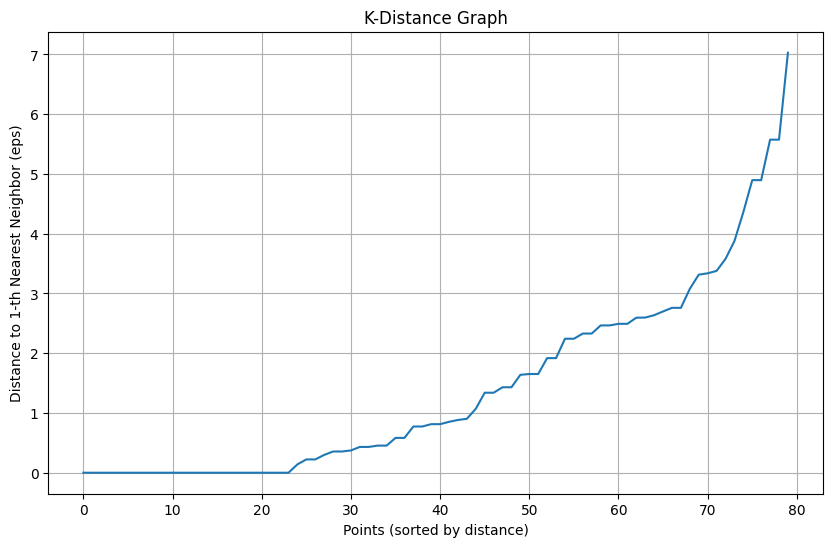

In [21]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 1. Get embeddings for the entire training set
# -----------------------------------------------

all_embeddings = []
trained_feature_extractor = FeatureExtractor(model) # Make sure this is defined
trained_feature_extractor.eval()

# Use the full dataset loader from your training script
full_train_dataset = DNADataset(train_df, label_encoder)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE)

with torch.no_grad():
    for sequences, _ in full_train_loader:
        sequences = sequences.to(DEVICE)
        embeddings = trained_feature_extractor(sequences)
        all_embeddings.append(embeddings.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings)

# 2. Calculate the k-distance graph
# -----------------------------------
# We set n_neighbors to min_samples (which is 2 in our case).
# We want the distance to the 1st nearest neighbor (k=1, since indexing is 0-based).
k = 2
nbrs = NearestNeighbors(n_neighbors=k).fit(all_embeddings)
distances, indices = nbrs.kneighbors(all_embeddings)

# Get the distance to the k-th neighbor (the second column, index 1)
k_distances = np.sort(distances[:, k-1], axis=0)

# 3. Plot the graph
# -------------------
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('K-Distance Graph')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'Distance to {k-1}-th Nearest Neighbor (eps)')
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "dna_classifier.pth")

In [ ]:
model = SimpleDNA_CNN()

model.load_state_dict(torch.load("DeepTide_v0.pth", map_location=torch.device('cpu')))
model.eval()
classes = ['Cnidaria', 'Arthropoda', 'Porifera', 'Echinodermata']
label_encoder = LabelEncoder()
label_encoder.fit_transform(classes)
CLASSES = label_encoder.classes_
print(CLASSES)

In [ ]:
seq ="TGAAGACCTAAGCCCATAGCCTACCTGCAATAACCCTAGGGTACCAAATCGTCCGGCTGAGGTCTTGACGAATACTACGGAAATAGTATGATTTAAAGCCGGGGTCTGATTTACATATGTTATCCAAAAGCGCGTGCTCCACGTACGTGACGGCTGTCCCTTCGAGGAATCAGGATTGCCCCGTGGATATTGGACATCTCCAAAAGCTATTCCGACCCTCCCGCCTCGAGAGAAACCGACTAGGCTCTAATCAGTGACTACAGAGTTCGCGCCTTAACAAAGCCCACCACCAGCTAGGCT"
encoded_seq = one_hot_encode(seq)
input_tensor = torch.tensor(encoded_seq, dtype=torch.float32).unsqueeze(0).to("cpu")

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)
    probabilities = torch.softmax(output, dim=1)
    confidence = probabilities[0][predicted_class].item()*100

print(output)
print(probabilities)
predicted_label = label_encoder.inverse_transform(predicted_class.cpu().numpy())
print("Predicted class:", predicted_label[0])
print(f"Confidence: {confidence:.4f}")